# Travail 1 - Kepler et Runge-Kutta 4

## Introduction

Nous allons dans ce travail étudier la dynamique newtonienne du système Terre-Lune, en résolvant numériquement les équations de Newton. Nous prendrons pour conditions initiales dans le repère de la Terre que la Lune passe à son périgée ($362600000{\rm m}$) à une vitesse de $1083.4{\rm m/s}$. Nous vérifierons que la trajectoire est une ellipse et présenterons les paramètres calculés pour cette ellipse. Ensuite, nous nous intéresserons à l'ordre de convergence de la méthode utilisée. Enfin, nous étudierons la trajectoire d'un astéroïde qui traverse le centre de l'ellipse avec une vitesse $(v_x,v_y)=(-500{\rm m/s},500 {\rm m/s})$ lorsque la Lune est à son apogée.

## Système Terre - Lune

### Paramètres et conditions initiales

Tout d'abord, importons les librairies utiles à notre travail.

In [121]:
import numpy
from math import log,sqrt
from matplotlib import pyplot
%matplotlib inline

Ensuite, entrons les données caractéristiques du système. $T$ est la durée durant laquelle nous voulons simuler les trajectoires de la lune et de la Terre et $N$ est le paramètre qui définit le nombre de lignes des matrices de données de chaque astre.

In [122]:
T = 3600*24*30
dt = 10
N = 1+int(T/dt)

mT = 5.972*10**24
mL = 7.348*10**22
G = 6.67408*10**-11

Nous savons qu'une force gravitationnelle (force attractive) existe entre la Terre et la lune. Selon la loi de Newton, celle-ci s'écrit 

$${\bf F}_{L,T}=-{\bf F}_{T,L}=-Gm_T m_L\dfrac{{\bf x_L}-{\bf x_T}}{(x_L-x_T)^3}$$

pour deux masses $m_L$ et $m_T$ s'attirant avec des forces mutuellement opposées séparées d'une distance $r$ qui est la norme du vecteur partant du centre de la Terre jusqu'au centre de la lune. Nos conditions initiales étant données dans le repère de la Terre, nous allons résoudre les équations de Newton dans le repère de la Terre également. Nous avons donc besoin de reformuler notre équation avec comme variable le vecteur ${\bf r} = {\bf x_L}-{\bf x_T}$. 

$$ {\bf \ddot{r}_{LT}} = {\bf \ddot{x}_L}-{\bf \ddot{x}_T} = \frac{1}{m_L}{\bf F}_{L,T} - \frac{1}{m_T}{\bf F}_{T,L} = -Gm_T \dfrac{{\bf x_L}-{\bf x_T}}{(x_L-x_T)^3} - Gm_L\dfrac{{\bf x_L}-{\bf x_T}}{(x_L-x_T)^3}$$

Ce qui devient

$$ {\bf \ddot{r}_{LT}} = -G(m_T+m_L)\dfrac{{\bf r_{LT}}}{r_{LT}^3} $$

Nous allons tout d'abord transformer l'équation de Newton, qui est du deuxième ordre, en un système de deux équations du premier ordre. Pour ce faire, nous introduisons le vectreur $u_{LT} $ définit comme 

$$ u_{LT}  = \begin{pmatrix} x_{LT}\ , y_{LT}\ , v_{x\,LT}\ , v_{y\,LT}\end{pmatrix} $$

Notre système d'équations différentielles devient

$$ \dot{u}_{LT} = f(u_{LT}) $$ 

Nous obtenons donc

$$ f(u_{LT}) = \begin{pmatrix} v_{x\,LT}\ , v_{y\,LT}\ , -\dfrac{ m_T\, G\, x_{LT}}{ \left[x_{LT}^2 + y_{LT}^2\right]^{3/2}}\ , -\dfrac{ m_T\, G\, y_{LT}}{ \left[x_{LT}^2 + y_{LT}^2\right]^{3/2}}  \end{pmatrix} $$

Encodons à présent les conditions initiales. Nous nommons $dataLT$ la matrice de données de la lune dans le repère de la Terre. Elle comporte quatre colonnes. Chaque ligne se présentera comme $ u_{LT}  = \begin{pmatrix} x_{LT}\ , y_{LT}\ , v_{x\,LT}\ , v_{y\,LT}\end{pmatrix} $.

In [123]:
dataLT = numpy.empty((N,4)) 

# dataL0 = [362600000,0,0,1083.4*mT/(mT+mL)]
# dataT0 = [0,0,0,-1083.4*mL/(mT+mL)] #1083.4349740009823

dataLT0 = [362600000,0,0,1083.4349740009823]

dataLT[0] = dataLT0

### "Fonction d'évolution"

Nous ne généraliserons pas la fonction $f$ à plus de deux corps, par soucis de lisibilité car cela n'est pas nécessaire.
La première ligne de $out$ est la trajectoire de la Terre, la seconde celle de la Lune.

In [124]:
def f(uLT): 
    return numpy.array([uLT[2],uLT[3],-G*(mT+mL)*uLT[0]/(uLT[0]**2+uLT[1]**2)**(3/2),\
                        -G*(mT+mL)*uLT[1]/(uLT[0]**2+uLT[1]**2)**(3/2)])     

### Implémentation de Runge Kutta 4

Ci-dessous la méthode "Runge Kutta 4" appliquée directement à la trajectoire de la Lune.

In [125]:
def rk4(f,uLT,dt): 
    k1 = f(uLT)
    k2 = f(uLT+dt/2*k1)
    k3 = f(uLT+dt/2*k2)
    k4 = f(uLT+dt*k3)
    
    return uLT+dt/6*(k1+2*k2+2*k3+k4)

### Calcul de la trajectoire

Calculons maintenant la trajectoire. Notons que $dataLT[t]$ est le vecteur $u_{LT}$ input de $f$ au temps $t$.

In [126]:
for t in range(1,N):
    
    dataLT[t] = rk4(f,dataLT[t-1],dt)

Affichons la position de la lune dans le repère de la Terre

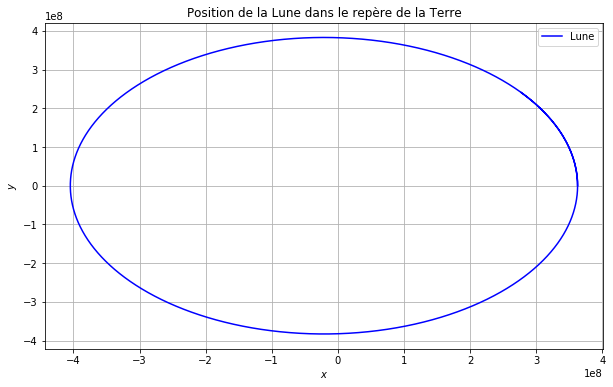

In [127]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(dataLT[:,0],dataLT[:,1], 'b-', label='Lune')
pyplot.title('Position de la Lune dans le repère de la Terre')
pyplot.legend();
pyplot.show();

### Paramètres : grand et petit axes, excentricité et période

Etant donné que la Lune commence sur l'axe $x$ avec une vitesse le long de $y$, les demi-grand axe $a$ et demi-petit axe $b$ sont alignés avec les axes $x$ et $y$ respectivement. Nous pouvons alors les calculer à par des minima et maxima de la trajectoire le long des composantes.

In [128]:
def computeParameters(posEllipse):
    a = 1/2*(numpy.max(posEllipse[:,0])-numpy.min(posEllipse[:,0]))
    b = 1/2*(numpy.max(posEllipse[:,1])-numpy.min(posEllipse[:,1]))
    e = numpy.sqrt(1-b**2/a**2)
    return numpy.array([a,b,e])

In [129]:
parameters = computeParameters(dataLT)

a = parameters[0]
b = parameters[1]
e = parameters[2]

print("a =", a)
print("b =", b)
print("e =", e)

a = 383663116.433
b = 383084497.255
e = 0.0549000295925


In [130]:
# Compute the parameters a,b,e

minX = 0
for i in range(1,N-1):
    if (dataLT[i+1,0]>=dataLT[i,0] and dataLT[i,0]<dataLT[i-1,0]):
        minX = dataLT[i,0]
        break
        
maxX = 0
for i in range(1,N-1):
    if (dataLT[i+1,0]<=dataLT[i,0] and dataLT[i,0]>dataLT[i-1,0]):
        maxX = dataLT[i,0]
        break

minY = 0
for i in range(1,N-1):
    if (dataLT[i+1,1]>=dataLT[i,1] and dataLT[i,1]<dataLT[i-1,1]):
        minY = dataLT[i,1]
        break
        
maxY = 0
for i in range(1,N-1):
    if (dataLT[i+1,1]<=dataLT[i,1] and dataLT[i,1]>dataLT[i-1,1]):
        maxY = dataLT[i,1]
        break
        
print("minX =", minX)
print("maxX =", maxX)
print("minY =", minY)
print("maxY =", maxY)
        
a = abs(maxX-minX)/2
b = abs(maxY-minY)/2
e = numpy.sqrt(1-b**2/a**2)

print("a =", a)
print("b =", b)
print("e =", e)

minX = -404726232.867
maxX = 362599999.995
minY = -383084497.255
maxY = 383084497.254
a = 383663116.431
b = 383084497.255
e = 0.0549000294758


In [131]:
# This method will not work for negative values of initial conditions

for i in range(2,N-1):
    if (dataLT[i+1,0]<=dataLT[i,0] and dataLT[i,0]>dataLT[i-1,0]):
        period = i*dt
        break
        
print("period in seconds =", period)
print("period in 24h-days =", period/24/3600)

period in seconds = 2350680
period in 24h-days = 27.206944444444446


Trouvons à présent l'apogée de l'orbite de la Lune autour de la Terre (cette donnée nous sera utile plus loin dans le travail).

In [132]:
for i in range(1,N-1):
    if (dataLT[i+1,0]>=dataLT[i,0] and dataLT[i,0]<dataLT[i-1,0]):
        indexApogee = i
        break

uLT_apogee = dataLT[indexApogee]
print(uLT_apogee)

[ -4.04726233e+08   8.74554030e+02  -2.21930424e-03  -9.70664834e+02]


### Ordre de convergence

Implémentons une fonction qui quantifie l'erreur sur les résultats de la simulation. Notre fonction prend les résultats calculés pour un certain dt ainsi que les données calculées avec le plus petit dt disponible et renvoie la valeur absolue de la différence entre le demi-grand axe des ellipses calculée dans les deux cas.

In [133]:
def get_diffgrid(data_current, data_fine):
    
    #parameters_current = computeParameters(data_current)
    #parameters_fine = computeParameters(data_fine)
    
    #diffgrid = abs(parameters_current[0]-parameters_fine[0])
    
    diffgrid = abs(data_current[-1,0]-data_fine[-1,0])
    
    return diffgrid

Calculons maintenant la trajectoire de la Lune pour plusieurs pas de temps différents 

In [134]:
r = 2

#h = 10
h = 1000
dt_values = numpy.array([h, r*h, r**2*h, r**3*h])

dataLT_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    
    N2 = int(T/dt)+1
        
    dataLT = numpy.empty((N2, 4))
    
    dataLT[0] = dataLT0

    for t in range(1,N2):
        dataLT[t] = rk4(f, dataLT[t-1], dt)
    
    dataLT_values[i] = dataLT

Calculons les erreurs par rapport à nos données les plus fine grâce à notre fonction get_diffgrid 

In [135]:
diffgridLT = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i in range(len(dt_values)):
    
    diffgridLT[i] = get_diffgrid(dataLT_values[i], dataLT_values[0])

In [136]:
print(diffgridLT)

[0.0 0.031296491622924805 0.55216765403747559 9.5351797938346863]


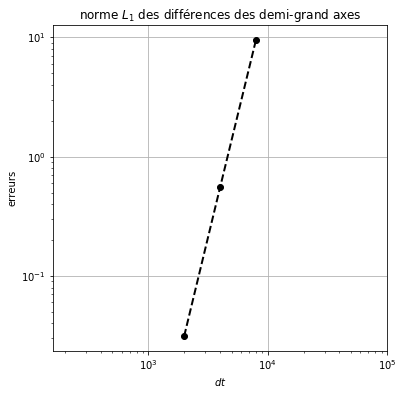

In [137]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.title(r'norme $L_1$ des différences des demi-grand axes')
pyplot.xlabel(r'$dt$')
pyplot.ylabel(r'erreurs')
pyplot.xlim(1e-4,1)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[1:], diffgridLT[1:], color='k', ls='--', lw=2, marker='o');

Calculons enfin l'ordre de convergence $\alpha$ à partir de ces erreurs

In [138]:
alpha = numpy.empty_like(dt_values[:-2], dtype=numpy.ndarray)

for i in range(1, len(dt_values)-1):
    
    #alpha[i-1] = (log(diffgridLT[i+1])-log(diffgridLT[i])) / log(r)
    alpha[i-1] = (log(get_diffgrid(dataLT_values[i+1], dataLT_values[i]))\
                  -log(get_diffgrid(dataLT_values[i], dataLT_values[i-1]))) / log(r)

print(alpha)

[4.056853722365219 4.108200812713604]


## Système Terre-Lune théorique

Calculons à présent analytiquement la période. Premièrement, nous connaissons la relation permettant de trouver la position du centre de masse:
$$ R_{CM} = \dfrac{ m_T \mathbf{x_T} + m_L \mathbf{x_L}}{m_t + m_L}$$

Deuxièmement, nous savons que la force de gravité est une force centrale et donc $\mathbf{x} \times \mathbf{F} = \dfrac{d\mathbf{L}}{dt} = 0$ pour $\mathbf{L} = \mu \mathbf{x} \times \mathbf{\dot{x}}$ le moment cinétique de la Lune et pour $\mu = \dfrac{m_L m_T}{m_T+m_L}$. Nous obtenons que $\mathbf{L}$ est une constante du mouvement. Il nous est permis également de considérer un plan dont un vecteur normal est $\mathbf{L}$. C'est dans ce dernier que se meut la Lune puisque $\mathbf{L} \perp \mathbf{x}$ et $\mathbf{L} \perp \mathbf{\dot{x}}$.

Ensuite, comme nous l'avons vu précédemment, ${\mathbf r} = {\mathbf x_L}-{\mathbf x_T}$. Nous obtenons ainsi
$$ \left\{
\begin{array}{c}
 \mathbf{x_L} = \mathbf{R_{CM}} + \dfrac{m_T}{m_T + m_L} \mathbf{r}\\
  \mathbf{x_T} = \mathbf{R_{CM}} - \dfrac{m_L}{m_T + m_L} \mathbf{r} 
\end{array}
\right.$$

Nous recalculons l'énergie totale du système ainsi que le moment cinétique total:
$$\begin{array}{c}
  &E_{tot} = \dfrac{1}{2} m_L \mathbf{\dot{x}_L} + \dfrac{1}{2} m_T \mathbf{\dot{x}_T} + U(\|\mathbf{x_L} - \mathbf{x_T}\|) = \dfrac{1}{2} \mu \mathbf{\dot{r}}^2 + \dfrac{1}{2} (m_T + m_L) \mathbf{\dot{R}^2_{CM}} + U(r)\\
  &\mathbf{L}_{tot} = m_L \mathbf{x_L} \times \mathbf{\dot{x}_L} + m_T \mathbf{x_T} \times \mathbf{\dot{x}_T} = (m_T + m_L) \mathbf{R_{CM}} \times \mathbf{\dot{R}_{CM}} + \mu \mathbf{r} \times \mathbf{\dot{r}}
\end{array}$$

Plaçons-nous à présent dans le repère de la Terre. Nous ne considérons donc plus le mouvement du centre de masse (assez flou). Nous retranscrivons l'énergie et le moment cinétique dans ce repère:
$$ \begin{array}{c}
E = \dfrac{1}{2} \mu \mathbf{\dot{r}}^2 + U(r)\\
\mathbf{L} = \mu \mathbf{r} \times \mathbf{\dot{r}}
\end{array}$$

Nous passons en coordonnées polaires $(r, \theta)$ de sorte que
$$\begin{equation}
\mathbf{\dot{r}}^2 = \dot{r}^2 + r^2 \dot{\theta}^2
\end{equation}$$

En outre, pour $L = \|\mathbf{L}\|$ et $S$ l'aire balayée par $\mathbf{r}$ pendant un temps $t$,
$$\begin{equation}
\dfrac{dS}{dt} = \dfrac{1}{2} \|\mathbf{r} \times \mathbf{\dot{r}} \| = \dfrac{L}{2\mu}
\end{equation}$$

que nous réécrivons
$$\begin{equation}
\dfrac{ds}{dt} = \dfrac{1}{2} r^2 \dot{\theta} = \dfrac{L}{2\mu}
\end{equation}$$

Il s'en suit que 
$$E = \dfrac{1}{2} \mu (\dot{r}^2 + r^2 \dot{\theta}^2) + U(r) = \dfrac{1}{2} \mu \dot{r}^2 + \dfrac{L^2}{2\mu r^2} - \dfrac{G m_T m_L}{r}$$

Cette équation différentielle se résout facilement en posant $u = \dfrac{1}{r}$ et en voyant que 
$$ \dfrac{du}{d\theta} = -\dfrac{1}{r^2}{dr}{d\theta} = -\dfrac{1}{r^2}{\dot{r}}{\dot{\theta}} = -\dfrac{\mu}{L}\dot{r}$$

Par cette substitution, il résulte l'équation suivante:
$$ \dfrac{1}{2} \left(\dfrac{du}{d\theta}\right)^2 + \dfrac{1}{2} \left(u-\dfrac{\mu G m_L m_T}{L^2}\right)^2 = \dfrac{\mu E}{L^2} +\dfrac{\mu^2 (G m_T m_L)^2}{2 L^4}$$

que nous dérivons par rapport à $\theta$: 
$$\dfrac{d^2u}{d\theta^2} = \dfrac{\mu G m_L m_T}{L^2} - u$$

et qui a comme solution:
$$u(\theta) = \dfrac{\mu G m_L m_T}{L^2} (1+\epsilon \cos(\theta - \theta_0)$$

où $\theta_0$ est l'angle initial (dans notre problème, $\theta_0 = 0$) et où $e$ est l'excentricité de l'orbite.
$$\epsilon = \sqrt{1+\dfrac{2EL^2}{\mu (G m_T m_L)^2}}$$

qui se retraduit en terme de $r$ par:
$$r(\theta) = \dfrac{L^2}{\mu G m_T m_L} \dfrac{1}{1+\epsilon \cos(\theta)}$$

Si nous changeons à nouveau de coordonnées:
$$ \left\{
\begin{array}{c}
 \bar{x} = r\cos(\theta) + \dfrac{\epsilon L^2}{\mu G m_T m_L (1 - \epsilon^2)}\\
 \bar{y} = r \sin(\theta) 
\end{array}
\right.$$

alors nous trouvons une nouvelle équation de l'ellipse:
$$ \dfrac{\bar{x}}{a^2} + \dfrac{\bar{y}}{b^2} = 1$$

et les valeurs du demi-grand axe, $a$, et du demi-petit axe, $b$, par identification:
$$\begin{array}{c}
  a &= \dfrac{L^2}{\mu G m_T m_L(1-\epsilon^2)}\\
  b &= a\sqrt{1-\epsilon^2}  
\end{array}$$

Ceci nous permet de dire que:
$$L = \sqrt{\mu G m_T m_L a (1-\epsilon^2)}$$

et par la loi des aires:
$$\dfrac{S}{T} = \dfrac{L}{2\mu}$$

or si la Lune a parcouru l'orbite complètement, l'aire balayée par $\mathbf{r}$ vaudra $S =\pi ab = \pi a^2 \sqrt{1-\epsilon^2}$, donc
$$T = 2\pi \sqrt{\dfrac{\mu a^3}{G m_T m_L}} = \dfrac{2\pi a^{3/2}}{\sqrt{G(m_T+m_L)}}$$

## Système Terre - Lune - astéroïde

A présent, la partie avec l'astéroïde. Il faut tout d'abord repérer, dans le repère de la Terre, le centre de l'ellipse que parcours la Lune autour de la Terre.

In [139]:
#Xcenter = (maxX+minX)/2
#Ycenter = (maxY+minY)/2
Xcenter = 1/2*(numpy.max(dataLT[:,0])+numpy.min(dataLT[:,0]))
Ycenter = 1/2*(numpy.max(dataLT[:,1])+numpy.min(dataLT[:,1]))

La nouvelle fonction "d'évolution" du système doit maintenant faire évoluer le vecteur $u_{AT} = (x_{AT},y_{AT},v_{x\,AT},v_{y\,AT})$ des coordonnées de l'astéroïde dans le repère de la Terre. Nous négligeons l'influence de l'astéroïde sur l'évolution du vecteur $u_{LT}$ de la Lune qui restera donc inchangée. 

La force gravitationnelle agissant sur l'astéroïde se sépare en deux contributions: l'attraction de la Terre et celle de la Lune. Avec les notations introduites précédemment, nous pouvons écrire l'accélération de l'astéroïde dans le repère de la Terre comme 

$$ {\bf \ddot{r}_{AT}} = -G(m_T+m_A)\dfrac{{\bf r_{AT}}}{r_{AT}^3} - G m_L\dfrac{{\bf r_{AT}}-{\bf r_{LT}}}{(r_{AT}-r_{LT})^3}$$

Expression dont nous avons déjà décrit l'obtention du premier terme dans le cas de l'attraction Terre-Lune. Le deuxième terme n'est que l'expression de la simple attraction newtonienne de deux masses. Nous négligeons dans nos calculs la masse $m_A$ de l'astéroïde pour obtenir

$$ {\bf \ddot{r}_{AT}} \approx -G m_T\dfrac{{\bf r_{AT}}}{r_{AT}^3} - G m_L\dfrac{{\bf r_{AT}}-{\bf r_{LT}}}{(r_{AT}-r_{LT})^3}$$

In [140]:
def f_ast(uLT,uAT): 
    out = numpy.empty((2,4))  
    out[0] = numpy.array([uLT[2],\
                          uLT[3],\
                          -G*(mT+mL)*uLT[0]/(uLT[0]**2+uLT[1]**2)**(3/2),\
                          -G*(mT+mL)*uLT[1]/(uLT[0]**2+uLT[1]**2)**(3/2)])
    out[1] = numpy.array([uAT[2],\
                          uAT[3],\
                          -G*mT*uAT[0]/(uAT[0]**2+uAT[1]**2)**(3/2) + \
                          -G*mL*(uAT[0]-uLT[0])/((uAT[0]-uLT[0])**2+(uAT[1]-uLT[1])**2)**(3/2),\
                          -G*mT*uAT[1]/(uAT[0]**2+uAT[1]**2)**(3/2) + \
                          -G*mL*(uAT[1]-uLT[1])/((uAT[0]-uLT[0])**2+(uAT[1]-uLT[1])**2)**(3/2)])
    return out

Réécrivons la méthode de Runge-Kutta

In [141]:
def rk4_ast(f_ast,uLT,uAT,dt): 
    k1 = f_ast(uLT,uAT)
    k2 = f_ast(uLT+dt/2*k1[0,:],uAT+dt/2*k1[1,:])
    k3 = f_ast(uLT+dt/2*k2[0,:],uAT+dt/2*k2[1,:])
    k4 = f_ast(uLT+dt*k3[0,:],uAT+dt*k3[1,:])
    
    out = numpy.empty((2,4))
    out[0] = uLT+dt/6*(k1[0,:]+2*k2[0,:]+2*k3[0,:]+k4[0,:])
    out[1] = uAT+dt/6*(k1[1,:]+2*k2[1,:]+2*k3[1,:]+k4[1,:])
    
    return out

Nous avons précédemment trouvé l'instant où la lune est à l'apogée de sa trajectoire autour de la Terre. Nous pouvons donc entrer nos conditions initiales.

In [142]:
T = 3600*1.75*1
dt = 10
N = 1+int(T/dt)

mT = 5.972*10**24
mL = 7.348*10**22
G = 6.67408*10**-11

dataLT = numpy.empty((N,4)) 
dataAT = numpy.empty((N,4)) 

dataAT0 = [Xcenter, Ycenter,-500,500]

dataLT[0] = uLT_apogee
dataAT[0] = dataAT0

Calculons la trajectoire

In [143]:
for t in range(1,N):
    
    temp = rk4_ast(f_ast,dataLT[t-1],dataAT[t-1],dt)
    dataLT[t] = temp[0]
    dataAT[t] = temp[1]

Affichons la trajectoire

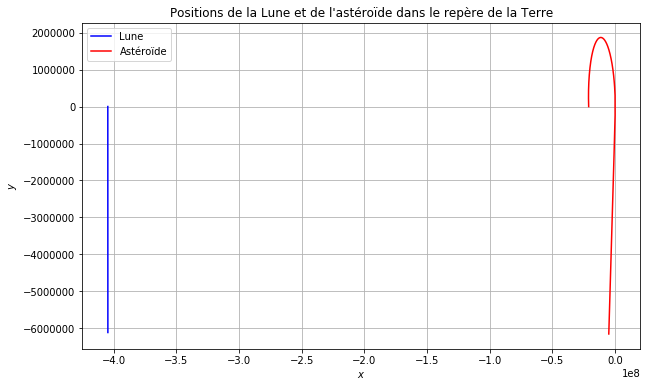

In [144]:
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(dataLT[:,0],dataLT[:,1], 'b-', label='Lune')
pyplot.plot(dataAT[:,0],dataAT[:,1], 'r-', label='Astéroïde')
pyplot.title('Positions de la Lune et de l\'astéroïde dans le repère de la Terre')
pyplot.legend();
pyplot.show();

### Etude de l'impact entre l'astéroïde et la Terre

LA POSITION ET VITESSE INITIALE DE LA LUNE CHANGENT LES RESULTATS QUANT A LA TRAJECTOIRE DE L ASTEROIDE (FAUSSE LIBERTE DE SIGNE)(CONDITIONS INITIALES DONNEES RELATIVEMENT POUR LA LUNE ET ABSOLUMENT POUR L'ASTEROIDE)

Nous commençons par encoder le rayon de la Terre

In [145]:
radiusT = 6371000

Nous cherchons ensuite l'instant de collision

In [146]:
indexImpact = 0

for t in range(1,N):
    
    if (dataAT[t,0]**2+dataAT[t,1]**2)<=radiusT**2:
        
        indexImpact = t
        break
        
print('Temps écoulé avant l\'impact =', indexImpact*dt, 'secondes')

Temps écoulé avant l'impact = 5630 secondes


Nous trouvons le point d'impact

In [147]:
print('Point d\'impact: x =', dataAT[indexImpact,0], ' y =', dataAT[indexImpact,1])

Point d'impact: x = -6060298.61029  y = 1647507.12772


Nous trouvons la norme de la vitesse d'impact

In [148]:
print('Vitesse d\'impact: v =', sqrt(dataAT[indexImpact,2]**2+dataAT[indexImpact,3]**2), 'm/s')

Vitesse d'impact: v = 9464.815921791213 m/s


## Animations

### Animation des trajectoires pour le système Terre-Lune

In [149]:
from matplotlib import animation
from IPython.display import HTML

Nous prendrons un pas de temps plus grand pour que la vidéo ne soit pas trop lourde. La précision n'est pas indispensable pour faire l'animation, à condition que le comportement obtenu soit fidèle à celui obtenu pour de petits pas de temps.

In [150]:
T = 3600*24*27.3
dt = 10000
N = 1+int(T/dt)

In [151]:
dataLT = numpy.empty((N,4)) 

dataLT[0] = dataLT0

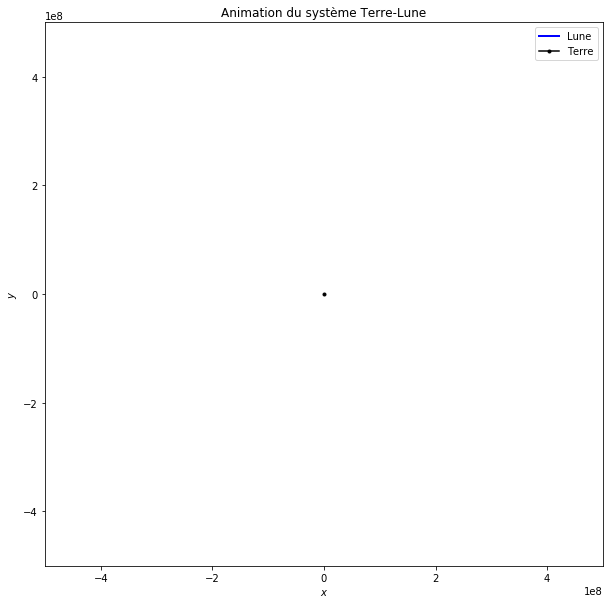

In [152]:
fig = pyplot.figure(figsize=(10,10))
ax = pyplot.axes(xlim=(-500000000,500000000), ylim=(-500000000,500000000))
line = ax.plot([], [], color='b', ls='-', lw=2, label='Lune')[0]
pointT=[[0,0]]
point = ax.plot(*zip(*pointT), marker='o', color='black', markersize=3, label='Terre')
pyplot.title('Animation du système Terre-Lune')
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.legend();

In [153]:
def trajectory(i):
    line.set_data(dataLT[:i,0],dataLT[:i,1])
    
    dataLT[i+1] = rk4(f,dataLT[i],dt)

In [154]:
anim = animation.FuncAnimation(fig, trajectory,
                               frames=N-1, interval=100)

In [155]:
HTML(anim.to_html5_video())

### Animation des trajectoires pour le système Terre-Lune-Astéroïde

Nous animerons ici que la trajectoire de l'astéroïde, la trajectoire de la Lune restant la même par hypothèse. Nous animerons la trajectoire jusqu'au moment de la collision, la suite n'étant que peu intéressante et n'ayant pas de sens physique.

In [156]:
T = 3600*2
dt = 10
N = 1+int(T/dt)

In [157]:
dataLT = numpy.empty((N,4)) 
dataAT = numpy.empty((N,4)) 

dataLT[0] = dataLT0
dataAT[0] = dataAT0

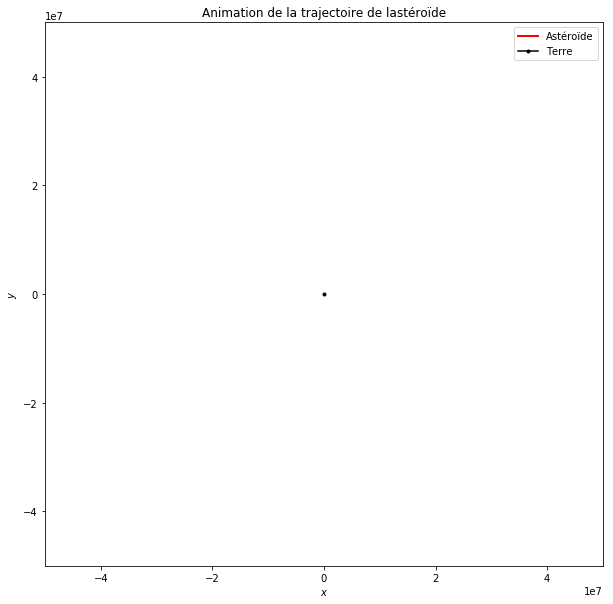

In [158]:
fig = pyplot.figure(figsize=(10,10))
ax = pyplot.axes(xlim=(-50000000,50000000), ylim=(-50000000,50000000))
lineA = ax.plot([], [], color='r', ls='-', lw=2, label='Astéroïde')[0]
pointT=[[0,0]]
point = ax.plot(*zip(*pointT), marker='o', color='black', markersize=3, label='Terre')  # évidemment pas à l'échelle!
pyplot.title('Animation de la trajectoire de l''astéroïde')
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.legend();

In [159]:
def trajectory_ast(i):
    lineA.set_data(dataAT[:i,0],dataAT[:i,1])
    
    temp = rk4_ast(f_ast,dataLT[i],dataAT[i],dt)
    dataLT[i+1] = temp[0]
    dataAT[i+1] = temp[1]

In [160]:
anim_ast = animation.FuncAnimation(fig, trajectory_ast,
                               frames=N-1, interval=5)

In [161]:
HTML(anim_ast.to_html5_video())

In [162]:
# NOTE: BIFURQUEMENT ASSEZ CURIEUX